In [1]:
# Import required packages
import numpy as np
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import scipy.optimize as optim
import copy
import random
import pickle

## 1) Load the dataset

For this project we are using the COMPAS-scores-two-years dataset, a COMPAS dataset that contains the criminal history, jail and prison time, demographics, and COMPAS risk scores for defendants from Broward county from 2013 and 2014, as well as the ground truth on whether or not these individuals actually recidivated within two years after the screening.  

There are 7214 data in total.

In [2]:
raw_data = pd.read_csv('../data/compas-scores-two-years.csv')

In [3]:
raw_data

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


## 2) Data processing

### 2.1) Subset of data with race "African-American" or "Caucasian"

We want to keep only the rows of the dataset that correspond to "African-American" or "Caucasian" race.

In [4]:
print("The dataset includes defendants of the following races: {}".format(raw_data['race'].unique()))

The dataset includes defendants of the following races: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Native American'
 'Asian']


In [5]:
processed_data = raw_data.loc[raw_data['race'].isin(["African-American", "Caucasian"])]

In [6]:
print("The original dataset includes {} African-American and Caucasian defendants.".format(processed_data.shape[0]))

The original dataset includes 6150 African-American and Caucasian defendants.


In [7]:
processed_data

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,10994,jarred payne,jarred,payne,2014-05-10,Male,1985-07-31,30,25 - 45,African-American,...,2,Low,2014-05-10,2015-10-22,2015-10-22,0,0,529,1,1
7208,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,9,High,2013-10-20,2014-04-07,2014-04-27,0,0,169,0,0
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0


### 2.2) Remove unuseful data

Remove unuseful columns (columns with multiple missing data).

In [8]:
processed_data = processed_data[['sex', 'age', 'age_cat', 'race', 'decile_score', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
            'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_charge_degree', 'is_recid', 
             'score_text', 'two_year_recid']]

In [9]:
processed_data

,sex,age,age_cat,race,decile_score,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_charge_degree,is_recid,score_text,two_year_recid
1,Male,34,25 - 45,African-American,3,0,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,F,1,Low,1
2,Male,24,Less than 25,African-American,4,0,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,F,1,Low,1
3,Male,23,Less than 25,African-American,8,0,1,0,1,NaN,NaN,NaN,F,0,High,0
6,Male,41,25 - 45,Caucasian,6,0,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,F,1,Medium,1
8,Female,39,25 - 45,Caucasian,1,0,0,0,0,-1.0,2014-03-15 05:35:34,2014-03-18 04:28:46,M,0,Low,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,Male,30,25 - 45,African-American,2,0,0,0,0,-1.0,2014-05-09 10:01:33,2014-05-10 08:28:12,M,1,Low,1
7208,Male,20,Less than 25,African-American,9,0,0,0,0,-1.0,2013-10-19 11:17:15,2013-10-20 08:13:06,F,0,High,0
7209,Male,23,Less than 25,African-American,7,0,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,F,0,Medium,0
7210,Male,23,Less than 25,African-American,3,0,0,0,0,-1.0,2014-01-31 07:13:54,2014-02-02 04:03:52,F,0,Low,0


According to the ProPublica COMPAS notebook (https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb) there are a number of reasons to remove rows because of missing data:
- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we can assume that because of data quality reasons, that we do not have the right offense.
- The recidivist flag (is_recid) should be -1 if we could not find a compas case at all.
- Ordinary traffic offenses (c_charge_degree = 'O') will not result in Jail time and hence are removed (only two of them).
- We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [10]:
# If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, 
# we can assume that because of data quality reasons, that we do not have the right offense.

processed_data = processed_data.loc[processed_data['days_b_screening_arrest'] <= 30]
processed_data = processed_data.loc[processed_data['days_b_screening_arrest'] >= -30]

In [11]:
# The recidivist flag (is_recid) should be -1 if we could not find a compas case at all.

processed_data = processed_data.loc[processed_data['is_recid'] != -1]

In [12]:
# Ordinary traffic offenses (c_charge_degree = 'O') will not result in Jail time and hence are removed 
# (only two of them).

processed_data = processed_data.loc[processed_data['c_charge_degree'] != 'O']

In [13]:
# score_text shouldn't be 'N/A'

processed_data = processed_data.loc[processed_data['score_text'] != 'N/A']

In [14]:
processed_data['length_of_stay'] = (pd.to_datetime(processed_data['c_jail_out'])-pd.to_datetime(processed_data['c_jail_in'])).apply(lambda x: x.days)

In [15]:
processed_data = processed_data.drop(columns=['c_jail_in', 'c_jail_out'])

### 2.3) Create indicator values out of columns

In [16]:
# replace the values of the sensitive attribute race as follows: Caucasian -> 1, African-American -> 0
processed_data = processed_data.replace({'race': 'Caucasian'}, 1)
processed_data = processed_data.replace({'race': 'African-American'}, 0)

In [17]:
# replace the values of sex as follows
processed_data = processed_data.replace({'sex': 'Male'}, 1)
processed_data = processed_data.replace({'sex': 'Female'}, 0)

# replace the values of age_cat as follows
processed_data = processed_data.replace({'age_cat': 'Less than 25'}, 0)
processed_data = processed_data.replace({'age_cat': '25 - 45'}, 1)
processed_data = processed_data.replace({'age_cat': 'Greater than 45'}, 2)

# replace the values of c_charge_degree as follows
processed_data = processed_data.replace({'c_charge_degree': 'F'}, 0)
processed_data = processed_data.replace({'c_charge_degree': 'M'}, 1)

# replace the values of score_text as follows
processed_data = processed_data.replace({'score_text': 'Low'}, 0)
processed_data = processed_data.replace({'score_text': 'Medium'}, 1)
processed_data = processed_data.replace({'score_text': 'High'}, 2)

### 2.4) Check for NaN values

In [18]:
# check whether there are NaN values in the final dataset as well as the number of unique values per column

unique_NAN_df = pd.DataFrame(columns=['column name', '# of unique values', '# of NaN values'])
for item in processed_data.columns:
    unique_NAN_df = unique_NAN_df.append({
        'column name': item, 
        '# of unique values': len(processed_data[item].unique()),
        '# of NaN values': sum(processed_data[item].isna() == True)}, ignore_index = True)
    
unique_NAN_df = unique_NAN_df.style.hide_index()
unique_NAN_df

column name,# of unique values,# of NaN values
sex,2,0
age,62,0
age_cat,3,0
race,2,0
decile_score,10,0
juv_fel_count,9,0
juv_misd_count,10,0
juv_other_count,8,0
priors_count,36,0
days_b_screening_arrest,56,0


In [19]:
# move two_year_recid to the end

cols = list(processed_data.columns.values)
cols.pop(cols.index('two_year_recid'))
processed_data = processed_data[cols+['two_year_recid']]

In [20]:
# move race to the first column

race_column = processed_data.pop('race')
processed_data.insert(0, 'race', race_column)

In [21]:
processed_data

,race,sex,age,age_cat,decile_score,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,score_text,length_of_stay,two_year_recid
1,0,1,34,1,3,0,0,0,0,-1.0,0,1,0,10,1
2,0,1,24,0,4,0,0,1,4,-1.0,0,1,0,1,1
6,1,1,41,1,6,0,0,0,14,-1.0,0,1,1,6,1
8,1,0,39,1,1,0,0,0,0,-1.0,1,0,0,2,0
10,1,1,27,1,4,0,0,0,0,-1.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,0,1,30,1,2,0,0,0,0,-1.0,1,1,0,0,1
7208,0,1,20,0,9,0,0,0,0,-1.0,0,0,2,0,0
7209,0,1,23,0,7,0,0,0,0,-1.0,0,0,1,1,0
7210,0,1,23,0,3,0,0,0,0,-1.0,0,0,0,1,0


In [22]:
processed_data = processed_data.drop(columns=['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count'])

In [23]:
# save final data set to csv

processed_data.to_csv("../output/processed-compas-scores-two-years.csv", index=False)

## 3) Split data

We will first get the labels and the sensitive data.

In [24]:
data = np.array(processed_data)
y = np.array(data[:,-1]).flatten()
data = data[:,:-1]
sensitive = data[:,0]
data = preprocessing.scale(data)
data = data[:,1:]

In [25]:
len(data[0])

9

Split data into sensitive and nonsensitive data (sensitive --> race: Caucasian)

In [26]:
sensitive_idx = np.array(np.where(sensitive==1))[0].flatten()
nonsensitive_idx = np.array(np.where(sensitive!=1))[0].flatten()
data_sensitive = data[sensitive_idx,:]
data_nonsensitive = data[nonsensitive_idx,:]
y_sensitive = y[sensitive_idx]
y_nonsensitive = y[nonsensitive_idx]

Split data into training, validation, and testing sets (training: validation: testing = 6:2:2).

In [27]:
# split sensitive data into training, validation, and testing sets

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(data_sensitive, y_sensitive, test_size= 0.2, random_state=42)
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_train_s, y_train_s, test_size = 0.25, random_state=42)

In [28]:
# split non-sensitive data into training, validation, and testing sets

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(data_nonsensitive, y_nonsensitive, test_size= 0.2, random_state=42)
X_train_n, X_valid_n, y_train_n, y_valid_n = train_test_split(X_train_n, y_train_n, test_size = 0.25, random_state=42)

In [29]:
# create final training, validation, and testing sets

X_train = np.concatenate((X_train_s, X_train_n))
X_valid = np.concatenate((X_valid_s, X_valid_n))
X_test = np.concatenate((X_test_s, X_test_n))

Y_train = np.concatenate((y_train_s, y_train_n))
Y_valid = np.concatenate((y_valid_s, y_valid_n))
Y_test = np.concatenate((y_test_s, y_test_n))

##  4) Learning Fair Representations (LFR)

In [30]:
# importing LFR Library

import sys
sys.path.append('../lib/')

from LFR import *
from EvalMetrics import *

#### Checking for best number of interations

In [52]:
iter_max = 1500

model_train_time = []
train_Accuracy = []
val_Accuracy = []
train_Calibration = []
val_Calibration = []

best_accuracy = 0

for i in range(100, iter_max+100, 100):

    #model training
    start = time.time()
    random.seed(1024); np.random.seed(1024)
    final_parameters = LFR(X_train_s, X_train_n, y_train_s, y_train_n, 10, 1e-4, 0.1, 1000, iter = i)
    model_train_time.append(time.time() - start)

    #Train set accuracy and calibration
    pred_train_s, pred_train_n = predict(final_parameters, X_train_s, X_train_n, 10)
    acc_sen, acc_nsen, total_accuracy = calc_accuracy(pred_train_s, pred_train_n, y_train_s, y_train_n)
    train_Accuracy.append(total_accuracy)

    calibration = calc_calibration(acc_sen, acc_nsen)
    train_Calibration.append(calibration)

    #Validation set accuracy and calibration
    pred_val_s, pred_val_n = predict(final_parameters, X_valid_s, X_valid_n, 10)
    acc_sen, acc_nsen, total_accuracy = calc_accuracy(pred_val_s, pred_val_n, y_valid_s, y_valid_n)
    val_Accuracy.append(total_accuracy)

    calibration = calc_calibration(acc_sen, acc_nsen)
    val_Calibration.append(calibration)

    if total_accuracy > best_accuracy:
    best_accuracy = total_accuracy
    best_model = copy.deepcopy(final_parameters)

    print("Finished for " + str(i) + " iterations in " + str(time.time() - start) + " secs")

Finished for 100 iterations in 483.8019828796387 secs
Finished for 200 iterations in 464.94515585899353 secs
Finished for 300 iterations in 464.09896755218506 secs
Finished for 400 iterations in 619.2527780532837 secs
Finished for 500 iterations in 772.3990051746368 secs
Finished for 600 iterations in 926.7830367088318 secs
Finished for 700 iterations in 929.1234676837921 secs
Finished for 800 iterations in 1086.281757593155 secs
Finished for 900 iterations in 1239.2414331436157 secs
Finished for 1000 iterations in 1545.072824716568 secs
Finished for 1100 iterations in 1545.8614144325256 secs
Finished for 1200 iterations in 1852.5381484031677 secs
Finished for 1300 iterations in 1854.4370942115784 secs
Finished for 1400 iterations in 1863.91064119339 secs
Finished for 1500 iterations in 2164.147953748703 secs


In [54]:
filename = '../output/best_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

#!cp "best_model.sav" "/content/drive/My Drive/Colab Notebooks/ADS Proj 4"

In [55]:
iterations = [i for i in range(100, iter_max+100, 100)]

print(iterations)
print(model_train_time)
print(train_Accuracy)
print(val_Accuracy)
print(train_Calibration)
print(val_Calibration)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
[482.6186888217926, 463.76605224609375, 462.9178469181061, 618.0655224323273, 771.2071952819824, 925.6012146472931, 927.9301013946533, 1085.0964105129242, 1238.0636746883392, 1543.890700340271, 1544.6894094944, 1851.3586659431458, 1853.2682836055756, 1862.7219052314758, 2162.971263408661]
[0.40998104864181933, 0.40998104864181933, 0.40998104864181933, 0.42766898294377764, 0.3641819330385344, 0.3708149084017688, 0.3708149084017688, 0.42103600758054327, 0.44504106127605814, 0.41819330385344283, 0.41819330385344283, 0.42703727100442196, 0.42703727100442196, 0.42703727100442196, 0.37397346809854703]
[0.45454545454545453, 0.45454545454545453, 0.45454545454545453, 0.47821969696969696, 0.3721590909090909, 0.39109848484848486, 0.39109848484848486, 0.4696969696969697, 0.4943181818181818, 0.4460227272727273, 0.4460227272727273, 0.45928030303030304, 0.45928030303030304, 0.45928030303030304, 0.38257575757575757]
[0.0

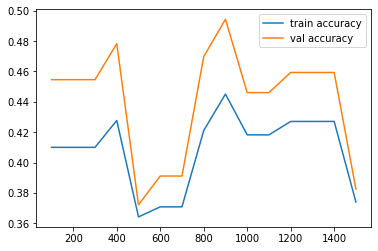

<Figure size 432x288 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt

plt.plot(iterations, train_Accuracy, label = "train accuracy")
plt.plot(iterations, val_Accuracy, label = "val accuracy")
plt.legend()
plt.savefig("../output/accuracy.png")
plt.show()

#!cp "accuracy.png" "/content/drive/My Drive/Colab Notebooks/ADS Proj 4"

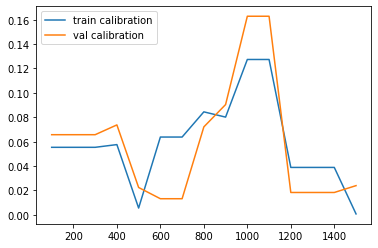

<Figure size 432x288 with 0 Axes>

In [60]:
plt.plot(iterations, train_Calibration, label = "train calibration")
plt.plot(iterations, val_Calibration, label = "val calibration")
plt.legend()
plt.savefig("../output/calibration.png")
plt.show()

#!cp "calibration.png" "/content/drive/My Drive/Colab Notebooks/ADS Proj 4"

In [58]:
# Saving the iterations data

df = pd.DataFrame(list(zip(iterations, model_train_time, train_Accuracy, val_Accuracy, train_Calibration, val_Calibration)), 
                  columns =['iterations', 'model_train_time', 'train_Accuracy', 'val_Accuracy', 'train_Calibration', 'val_Calibration'])

In [59]:
df.to_csv("../output/All_iterations_info.csv", index=False)

#!cp "All_iterations_info.csv" "/content/drive/My Drive/Colab Notebooks/ADS Proj 4"

#### BEST MODEL

In [31]:
filename = '../output/best_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

##### Training Set

In [32]:
# get predictions for the training dataset

pred_train_s, pred_train_n = predict(loaded_model, X_train_s, X_train_n, 10)

# get accuracy for the training dataset

acc_sen, acc_nsen, total_accuracy = calc_accuracy(pred_train_s, pred_train_n, y_train_s, y_train_n)

print("The accuracy for Caucasians is: ", acc_sen)
print("The accuracy for African-Americans is: ", acc_nsen)
print("The total accuracy is: ", total_accuracy)

# get calibration for the training dataset

calibration = calc_calibration(acc_sen, acc_nsen)

print("The calibration is: ", calibration)

NameError: name 'distances' is not defined

##### Validation Set

In [ ]:
# get predictions for the validation dataset

pred_val_s, pred_val_n = predict(loaded_model, X_valid_s, X_valid_n, 10)

# get accuracy for the validation dataset

acc_sen, acc_nsen, total_accuracy = calc_accuracy(pred_val_s, pred_val_n, y_valid_s, y_valid_n)

print("The accuracy for Caucasians is: ", acc_sen)
print("The accuracy for African-Americans is: ", acc_nsen)
print("The total accuracy is: ", total_accuracy)

# get calibration for the validation dataset

calibration = calc_calibration(acc_sen, acc_nsen)

print("The calibration is: ", calibration)

## 5) Evaluation

##### Testing set

In [ ]:
# get predictions for the testing dataset

pred_test_s, pred_test_n = predict(loaded_model, X_test_s, X_test_n, 10)

# get accuracy for the testing dataset

acc_sen, acc_nsen, total_accuracy = calc_accuracy(pred_test_s, pred_test_n, y_test_s, y_test_n)

print("The accuracy for Caucasians is: ", acc_sen)
print("The accuracy for African-Americans is: ", acc_nsen)
print("The total accuracy is: ", total_accuracy)

# get calibration for the testing dataset

calibration = calc_calibration(acc_sen, acc_nsen)

print("The calibration is: ", calibration)